# Neural Style Transfer using Tensorflow : Detailed Implementation
![Styled Image](https://www.kaggleusercontent.com/kf/55976898/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..-L3nn_VIbjvA41N1uFozgQ._HHISEnNKQwbxUyLFlikLges7_kisIkOqt0XsNrHIOtF3aXCkYYSIyEycHZ08KaMP98gYv0MODMSw0tDJdZpTVuV5ioKl6zFqKUCAEwitL6u6w0i5nl26ZWkR9A8H8reclQxoDvX7fccVi7yR2luXL4e2PKRhbiCpb50iLNC8svGc12sw53EqMJPj4wEwB7qNfPI7tQrOOiIOHYCYi98a8K8DrQ4fFx5t4ZJ2H7YTSrT4Jdz0rdYJghXSCbrgkshe6txSdgX8wVIC_JsExG4SPwG4jH6pPnoJg8To4rMQ2NOSlC9Ugce8MmiC5kAuJLpej3u6RAAB0LhuP1rKObLeRvE9vizOPIkZ9vkfSkw9VH8WYCBMj3zut-Pvzx5ScblblVbtLpqgtthZYr7ZABRvptLwfnRj5KPKSLXr7H70Ymmpbg-GBix38v4-Dfyxre8d-pz6zog3-YKW9NHhE2EGoddo5met0-r5_31NpuVW7s2_skF5NSmafkLGg6tVBl5mBfIhSui46HqiEt6c7sDwukOCWtWOxLhFSfrvfkOkagHmVwM7sI8mfACs-vBpVeos9WV7Vi_u1JSybdfzU_c70-OVJ8ojWWLrs6xbhyYfVElha9f05bRiHyJirT_731X0CiPRQWkLtz1Lae_t-jA5KjG_IGnyRohYi09cyR3faY.ZK8vJcNBHOQXATx6Q2xZ1A/__results___files/__results___23_3.png)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# setting seeds for fixed pseudo-random numbers in repeated runs
np.random.seed(7)
tf.random.set_seed(7)

# Importing Base Model

Before you proceed, I highly recommend you read the [Style Transfer](https://arxiv.org/pdf/1508.06576.pdf) research paper or watch [Andrew Ng's explanation](https://www.youtube.com/watch?v=R39tWYYKNcI&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=38) of it on youtube. If you did both then Kudos to you :)

* In accordance to the reserach paper, I'll import the `VGG19 model` provided by keras which is pretrained on ImageNet dataset.

* Note that we have to `drop the upper fully connected layers` as we are not interested in predictions. We are after the feature maps residing in the convolution layers.

* Also, `freeze the weights` as we don't want the neural net to learn anything. We are just altering the noisy input in accordance to the content and style images.

* In a CNN, the `earlier Conv-layers` detect low level features like vertical and horizontal edges and Conv-layers at the end of the Neural Network detect high level features like faces, or presence of a particular object or features.

* Therefore, we use the `end layer/layers` for content loss and the earlier layers for style.

In [2]:
# Content layers
content_layers = ['block5_conv2'] 

# Style layers
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [3]:
def get_model():
  # Load our model. We load pretrained VGG, trained on imagenet data (weights=’imagenet’)
    vgg19 = keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
    vgg19.trainable = False
    
  # Get output layers corresponding to style and content layers 
    content_outputs = [vgg19.get_layer(name).output for name in content_layers]
    style_outputs = [vgg19.get_layer(name).output for name in style_layers]
    
  # Build model 
    return keras.models.Model(inputs = [vgg19.input], outputs = [content_outputs, style_outputs])

# Image Processing Functions

* Neural nets expect a constant input-size
* The `deprocess_image` function is needed as `vgg19.preprocess_input` method normalises the input and changes rgb to bgr. So we have to de-process to get the output back into rgb form.

In [4]:
def preprocess_image(image):
    '''
    Takes an input of any size and resizes it to 500 x 500 along with applying the preprocessing erquired by vgg19
    '''
    image = keras.preprocessing.image.img_to_array(image)
    image = tf.image.resize(image, [500, 500])
    image = tf.expand_dims(image, axis=0)
    image = keras.applications.vgg19.preprocess_input(image)
    return image

In [5]:
def deprocess_image(processed_image):
    '''
    Takes the output_image from vgg19 and removes the processing applied by vgg19.preprocess_input
    '''
    x = processed_image.numpy().copy()
    x = np.squeeze(x, 0)
    
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert back to RGB from BGR

    x = np.clip(x, 0, 255).astype('uint8')
    return x

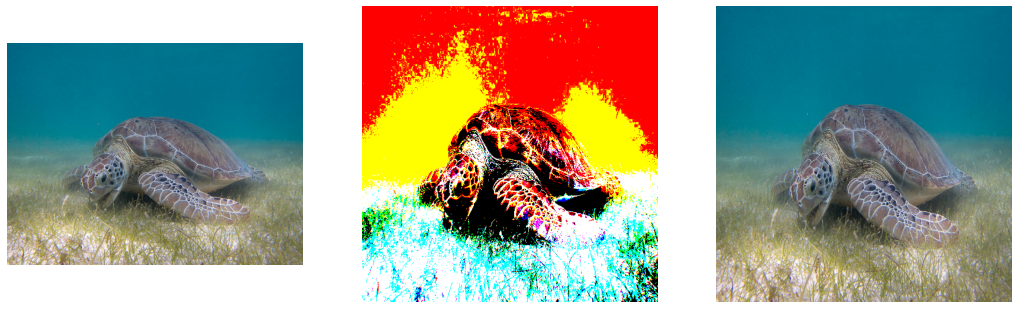

In [6]:
trial_image = plt.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg/1200px-Green_Sea_Turtle_grazing_seagrass.jpg", format='jpg')
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(trial_image)
plt.axis('off')

plt.subplot(1,3,2)
# preprocessed image is of shape (1, 500, 500, 3)
# preprocess_image(trial_image)[0] removes the first axis
plt.imshow(preprocess_image(trial_image)[0])
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(deprocess_image(preprocess_image(trial_image)))
plt.axis('off')

plt.show()

# Loss Functions
* I use the term `all_` when I'm using data from many layers.

* For example `all_feature_maps` is set of feature-maps from layers 1,2,3 and so on. It will have a group of fmaps from layer-1, another group of fmaps from layer-2.

* Writing `feature_maps` means the fmaps are of particular layer alone.

**Example:** `for content_maps, noise_content_maps in zip(all_content_maps, all_noise_content_maps):`

Here I iterate over the fmaps from different layers and at a particular iteration grab the fmaps of that particular layer alone.

# Content Loss

Calculating the content loss is simple: Alter the noise image so as to reduce the Euclidean distance between the feature-maps generated by the noise and the content image.

This is how we do that:
Assuming we are using multiple layers for calculating the content loss
* Iterate over the layers.

* Say we use 4 layers, then we iterate over them and in the first run grab the 1st layer which we are using for content loss.
* Calculate the Euclidean distance between the feature maps.
* Add that to the net content loss.
* Grab the second layer which we are using for calculating the content loss.
* Calculate the Euclidean distance between its feature maps.
* Add that to the net content loss.

and so on till all layers are used up. Note that we divide the loss at each iteration by the number of layers we use.

In [7]:
def content_loss_func(all_content_maps, all_noise_content_maps):
    '''
    Takes in the feature-maps from content-layers; iterates over each of them; and at each iteration calculates the Euclidean Distnce
    
    all_content_maps: output of the content_layers when content_image is passed through the model
    
    all_noise_content_maps: output of the content_layers when noise is passed through the model
    
    returns content_loss
    '''
    
    content_loss = 0.
    content_weight = 1/num_content_layers
    
#     use for loop just in case we try more than one content layer
#     we use [0] becuase without that, content_maps is of dtype list, which is unsupported
    for content_maps, noise_content_maps in zip(all_content_maps, all_noise_content_maps):
        content_loss += content_weight * tf.reduce_mean(tf.square(content_maps[0] - noise_content_maps[0]))
        
    return content_loss

# Style Loss

* Style loss is reduced by reducing the difference between the Gram-Matrices of feature maps.

* Note that (and this is very important) the output of a Conv-layer is a bunch of feature-maps. What we do is that we find the `correlation` between these feature-maps and store that as the `gram-matrix`.

* Say a Conv-Layer outputs 7 feature-maps. Then we can imagine the gram-matrix as a table in which the x-axis is labelled: fmaps 0,1,2,3,4,5,6 and y-axis is also labelled fmaps 0,1,2,3,4,5,6. The entries in the table will be the correlation between those feature maps i.e entry 1,3 in the table will be correlation between fmap 1 and fmap 3. (Of course, the gram-matrix will be symmetric with mirrored data acoss the diagonal).

* `Correlation` is calculated by element-wise multiplying matrices and summing the values of the result.

* The `calculation of the gram-matrix` is tricky and very hard to understand by reading the code and it is further complicated by the image notation being in channels last notation used in libraries, but I've tried my best to explain it down below with an example.

* The Style_loss function iterates across the layers.

* At a particular, it calcualtes the gra matrix using the fmaps of the style_image and a seperate gram_matrix using the fmaps of the noise.

* Then it computes the `euclidean distance between the gram-matrices`.

* Same is done for each layer and the loss is collected in a net_loss.

In [8]:
def gram_matrix(maps):
    '''
    Takes in feature-maps of a particular layer and computes the gram-matrix for that set of fmaps.
    
    '''
    channels = tf.shape(maps)[-1]
    maps = tf.reshape(maps, [-1, channels])
    gram_matrix = tf.matmul(a = maps, b = maps, transpose_a = True)
    return gram_matrix/tf.cast(maps.shape[0], tf.float32)

def style_loss_func(all_style_maps, all_noise_style_maps):
    '''
    Takes in the feature-maps from style-layers; and iterates over each of them.
    At each iteration it grabs the fmaps of that layer; computes the gram-matrices for the style_image fmaps and the noise fmaps;
    and computes the Euclidean Distance as the style loss.
    
    all_style_maps: output of the style_layers when content_image is passed through the model
    
    all_noise_content_maps: output of the style_layers when noise is passed through the model
    
    returns style_loss
    '''
    style_loss = 0.
    style_weight = 1/num_style_layers
    
    for style_maps, noise_style_maps in zip(all_style_maps, all_noise_style_maps):
        style_gram = gram_matrix(style_maps)
        noise_gram = gram_matrix(noise_style_maps)
        style_loss += style_weight * tf.reduce_mean(tf.square(style_gram - noise_gram))
    return style_loss

**An example to show how the Gram-matrix is being calculated in the above cell.**

```
arr = np.arange(12).reshape(2, 2,3)
arr = tf.constant(arr)

This is how you must have imagined it with. Three (Two by Two matrices), right?

array([[[ 0,  1],
        [ 2,  3]],

       [[ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11]]])


But below is how it actually looks:

<tf.Tensor: shape=(2, 2, 3), dtype=int64, numpy=
array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])>

Note that these are two (two by three) matrices and not three (two by two) matrices which is the actual concept of an rgb image.
Surprised? Angry? Ya me too. But it is what is is.

Matrix notation works like this: (5 x 4 x 3 x 2) means you have five (4 x 3 x 2) matrices each of which a group of four (3 x 2) matrices.

If we look at it with the earlier perspective, in our head we can view the data being distributed as follows:

array([[[ 0,  6],
        [ 3,  9]],

       [[ 1,  7],
        [ 4, 10]],

       [[ 2,  8],
        [ 5, 11]]])
```

```
arr = tf.reshape(arr, [-1, 3])
<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])>

This reshaping step makes no sense for the time being but you will see the subtlety in a minute.


tf.matmul(a = arr, b = arr, transpose_a=True) which gives:

<tf.Tensor: shape=(3, 3), dtype=int64, numpy=
array([[126, 144, 162],
       [144, 166, 188],
       [162, 188, 214]])>
       
Under the hood what it did is the following:

array([[ 0,  3,  6,  9],    array([[0,  1,  2],
       [ 1,  4,  7, 10],           [3,  4,  5],
       [ 2,  5,  8, 11]])          [6,  7,  8],
                                   [9, 10, 11]])
```

```
Now watch carefully:

array([[[ 0,  6],
        [ 3,  9]],

       [[ 1,  7],
        [ 4, 10]],

       [[ 2,  8],
        [ 5, 11]]])
        
If I ask you to find the correlation between channel-1 (the 0,3,6,9 one) and channel-2.
You would do the following: 

    [[0 x 1,  6 x 7],    =   [[0,  42],
     [3 x 4,  9 x 10]]       [12, 90]]
     
     sum = 0 + 42 + 12 + 90 = 144
     
     
This is exactly what is happening here when row1 multiplies col2:

array([[ 0,  3,  6,  9],      array([[0,  1,  2],         array([[126, 144, 162],
       [ 1,  4,  7, 10],   x         [3,  4,  5],    =           [144, 166, 188],
       [ 2,  5,  8, 11]])            [6,  7,  8],                [162, 188, 214]])
                                     [9, 10, 11]])
```

# Gradient Function

In [9]:
def get_gradients(model, all_content_maps, all_style_maps, noise):
    '''
    Computes the gradients for style transfer.
    
    model: The neural network which computes the feature-maps
    
    all_content_maps: pre-computed feature-maps outputed by content_layers of the model
    
    all_style_maps: pre-computed feature-maps outputed by style_layers of the model
    
    returns gradients, total_loss, content_loss, style_loss
    '''
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(noise)
        
        alpha, beta = 1e4, 1e-3
    
        noise_maps = model(noise)
        all_noise_content_maps = noise_maps[0]
        all_noise_style_maps = noise_maps[1]

        content_loss = content_loss_func(all_content_maps, all_noise_content_maps)
        style_loss = style_loss_func(all_style_maps, all_noise_style_maps)
        
        total_loss = alpha*content_loss + beta*style_loss
        
    return tape.gradient(total_loss, noise), total_loss, content_loss, style_loss

# Final Function

In [10]:
def style_transfer(content_image, style_image, epochs = 2000):
    '''
    Inputs: content_image, style_image, #epochs
    
    Outputs: A new image with the content of the content_image and the style of the style_image
    '''
    
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    noise = tf.Variable(preprocess_image(tf.random.uniform(shape=content_image.shape)))
    content_image = preprocess_image(content_image)
    style_image = preprocess_image(style_image)
    
    plt.figure(figsize=(18,6))
    for i, image in enumerate([content_image, style_image, noise]):
        plt.subplot(1,3, i+1)
        plt.imshow(deprocess_image(image))
        plt.axis('off')
    plt.show()
    
    content_output = model(content_image)
    all_content_maps = content_output[0]
    
    style_output = model(style_image)
    all_style_maps = style_output[1]
    
    optimizer = keras.optimizers.Adam(lr=10.0)
    
    best_loss, best_image = float('inf'), None
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    
    image_list = []
    
    for epoch in range(epochs):
        gradients, total_loss, content_loss, style_loss = get_gradients(model, all_content_maps, all_style_maps, noise)
        optimizer.apply_gradients([(gradients, noise)])
        clipped = tf.clip_by_value(noise, min_vals, max_vals)
        noise.assign(clipped)
        
        if total_loss < best_loss:
            best_loss = total_loss
            best_image = deprocess_image(noise)
            image_list.append(best_image)
            
        if epoch % 100 == 0:
            print("\nEpoch {}/{}".format(epoch, epochs))
            print('Total_loss', total_loss.numpy())
            print('Content_loss:', content_loss.numpy())
            print('Style_loss:', style_loss.numpy())
        
    plt.figure(figsize=(10,10))
    plt.imshow(best_image)
    plt.axis('off')
    plt.show()
            
    return (best_loss, best_image, image_list)

# Run

In [11]:
# make sure to set the correct format
content_image = plt.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg/1200px-Green_Sea_Turtle_grazing_seagrass.jpg", format='jpg')
style_image = plt.imread("https://upload.wikimedia.org/wikipedia/commons/a/a5/Tsunami_by_hokusai_19th_century.jpg", format='jpg')

80142336/80134624 [==============================] - 1s 0us/step


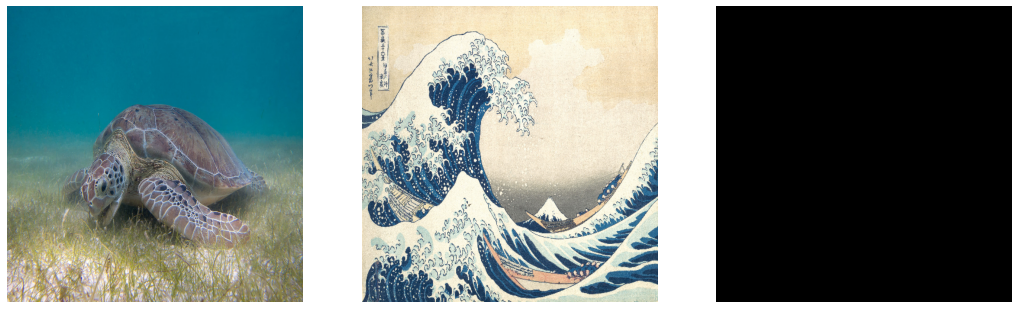


Epoch 0/2000
Total_loss 71813050.0
Content_loss: 1085.984
Style_loss: 60953207000.0

Epoch 100/2000
Total_loss 2845257.5
Content_loss: 135.67958
Style_loss: 1488461600.0

Epoch 200/2000
Total_loss 1819849.9
Content_loss: 92.10883
Style_loss: 898761540.0

Epoch 300/2000
Total_loss 1444022.5
Content_loss: 76.65246
Style_loss: 677497900.0

Epoch 400/2000
Total_loss 1281746.4
Content_loss: 70.94211
Style_loss: 572325300.0

Epoch 500/2000
Total_loss 1132491.9
Content_loss: 62.767147
Style_loss: 504820350.0

Epoch 600/2000
Total_loss 1047956.25
Content_loss: 57.993572
Style_loss: 468020500.0

Epoch 700/2000
Total_loss 1041931.9
Content_loss: 56.10024
Style_loss: 480929440.0

Epoch 800/2000
Total_loss 910448.94
Content_loss: 51.425137
Style_loss: 396197540.0

Epoch 900/2000
Total_loss 980644.1
Content_loss: 57.92719
Style_loss: 401372260.0

Epoch 1000/2000
Total_loss 831319.9
Content_loss: 47.34775
Style_loss: 357842370.0

Epoch 1100/2000
Total_loss 874732.44
Content_loss: 51.378017
Style_lo

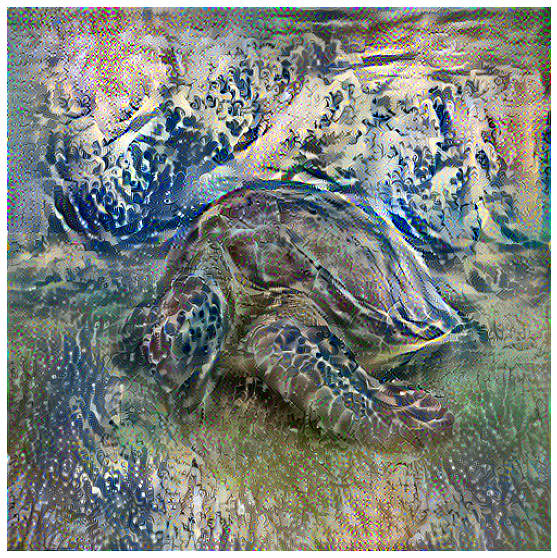

In [12]:
loss, image, image_list = style_transfer(content_image, style_image)

#if you are unable to scroll the output, collapse the output and then expand it again.